In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
import sklearn.metrics as metrics
import xgboost as xgb
from skopt import BayesSearchCV
import shap

# Initial Data Work:

#### Read in data

In [4]:
titanic_data = pd.read_csv('titanic_data.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### Preprocessing

In [5]:
# Check for nans
print(titanic_data.isna().sum()[titanic_data.isna().sum() > 0])

Age         177
Cabin       687
Embarked      2
dtype: int64


In [6]:
# Impute missing age with mean age
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].mean())

# Impute missing embarked with mode
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode().values[0])

# Create family size engineered feature
titanic_data['FamilySize'] = titanic_data['SibSp'] + titanic_data['Parch']

# Encode text columns
titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], drop_first=True)

# Create X and y
y = titanic_data.loc[:,'Survived']
X = titanic_data.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'], axis='columns')

print('Survivors and Casualties: \n', y.value_counts(normalize = True),'\n')

Survivors and Casualties: 
 0    0.616162
1    0.383838
Name: Survived, dtype: float64 



#### Feature Codependence

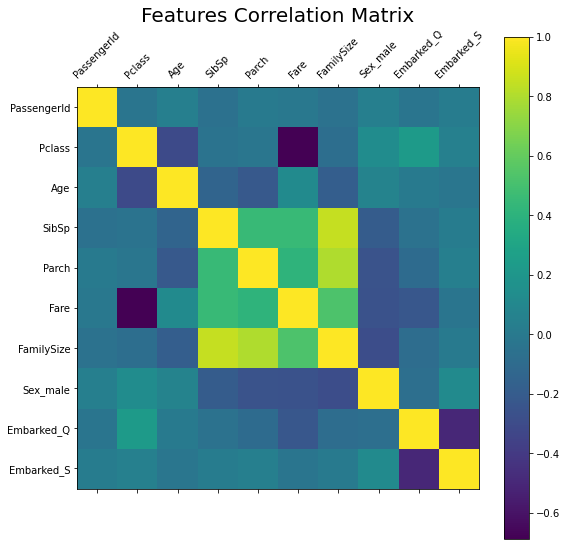

In [7]:
corr_mat = X.corr(method='spearman')
f = plt.figure(figsize=(9, 9))
plt.matshow(corr_mat, fignum=f.number)
plt.xticks(range(corr_mat.select_dtypes(['number']).shape[1]), corr_mat.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(corr_mat.select_dtypes(['number']).shape[1]), corr_mat.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Features Correlation Matrix', fontsize=20);

#### Hyperparameter tuning

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model = xgb.XGBClassifier(use_label_encoder=False, base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
                          gamma=0.0, max_delta_step=0.0, min_child_weight=1.0, missing=1, n_jobs=12,
                          objective='binary:logistic', random_state=42, reg_alpha=0.0, reg_lambda=1.0,
                          scale_pos_weight=1.0, tree_method='auto')

search_spaces = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
optimized_model = BayesSearchCV(estimator=model, search_spaces=search_spaces, n_jobs=12, cv=cv)
result = optimized_model.fit(X_train, y_train)

optimized_model.fit(X_train, y_train)
print('Val. Score:',optimized_model.best_score_)
print('Test Score:', optimized_model.score(X_test, y_test))
print('Best Params:', result.best_params_)

[13:44:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Val. Score: 0.8218667097590865
Test Score: 0.8116591928251121
Best Params: OrderedDict([('colsample_bytree', 0.7804550139846472), ('learning_rate', 0.05), ('max_depth', 2), ('n_estimators', 300), ('subsample', 0.9455944199371358)])


#### Re-evaluate the tuned model

In [11]:
# Instantiate tuned model
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0, gamma=0.0,
                          max_delta_step=0.0, min_child_weight=1.0, missing=1, n_jobs=-1,
                          objective='binary:logistic', random_state=42, reg_alpha=0.0,
                          reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
                          colsample_bytree = result.best_params_['colsample_bytree'], 
                          learning_rate = result.best_params_['learning_rate'], 
                          max_depth = result.best_params_['max_depth'], 
                          subsample = result.best_params_['subsample'], 
                          n_estimators = result.best_params_['n_estimators'])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Refit the model on k-folds to get stable avg error metrics
scores = cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, n_jobs=-1, scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

print('CV Results:\n')
print('AUC: ', scores['test_roc_auc'].mean())
print('Accuracy: ', scores['test_accuracy'].mean())
print('Precision: ', scores['test_precision'].mean())
print('Recall: ', scores['test_recall'].mean())
print('F1: ', scores['test_f1'].mean(), '\n')

CV Results:

AUC:  0.8483003578157682
Accuracy:  0.812894175737852
Precision:  0.7998177718543852
Recall:  0.6811764705882353
F1:  0.7338368861790616 



[13:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Classification report (Test): 

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       135
           1       0.79      0.72      0.75        88

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223

Confusion matrix (Test): 

[[0.52914798 0.07623318]
 [0.11210762 0.28251121]]

Train Accuracy: 0.874251497005988
Test Accuracy: 0.8116591928251121

Train AUC: 0.9261335539579291
Test AUC: 0.877104377104377


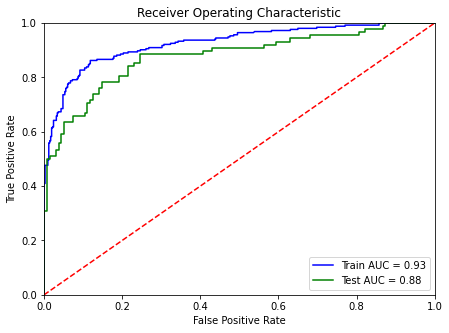

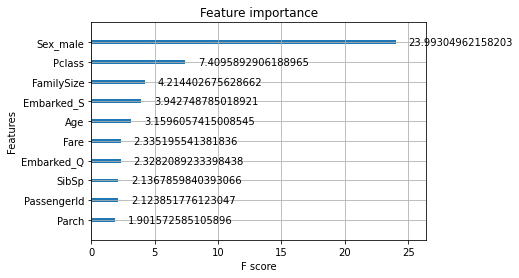

In [12]:
# Fit the final model
model.fit(X_train, y_train)

#Generate predictions against our training and test data
pred_train = model.predict(X_train)
proba_train = model.predict_proba(X_train)
pred_test = model.predict(X_test)
proba_test = model.predict_proba(X_test)

# Print model report
print("Classification report (Test): \n")
print(metrics.classification_report(y_test, pred_test))
print("Confusion matrix (Test): \n")
print(metrics.confusion_matrix(y_test, pred_test)/len(y_test))

print ('\nTrain Accuracy:', metrics.accuracy_score(y_train, pred_train))
print ('Test Accuracy:', metrics.accuracy_score(y_test, pred_test))

print ('\nTrain AUC:', metrics.roc_auc_score(y_train, proba_train[:,1]))
print ('Test AUC:', metrics.roc_auc_score(y_test, proba_test[:,1]))

# Calculate the fpr and tpr for all thresholds of the classification
train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_train, proba_train[:,1])
test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_test, proba_test[:,1])

train_roc_auc = metrics.auc(train_fpr, train_tpr)
test_roc_auc = metrics.auc(test_fpr, test_tpr)

fig, ax = plt.subplots(figsize=[7,5])
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Plot feature importance
xgb.plot_importance(model, importance_type='gain');

# A peak inside the blackbox using SHAP

In [13]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


#### Summary Plot

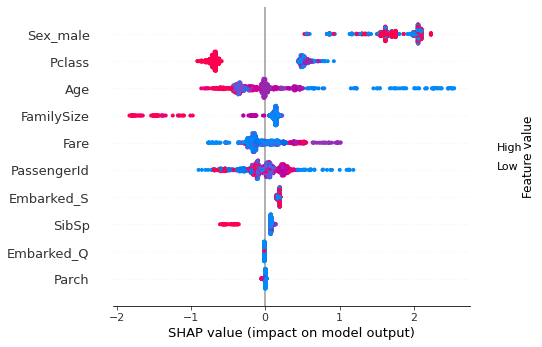

In [14]:
shap.summary_plot(shap_values, X)

#### Dependence Plots

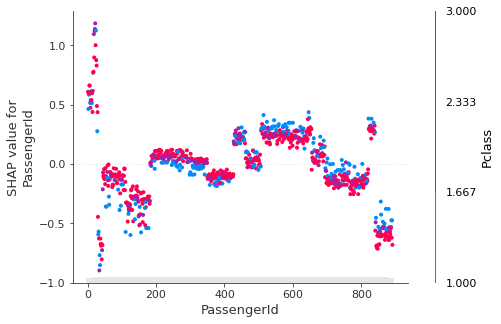

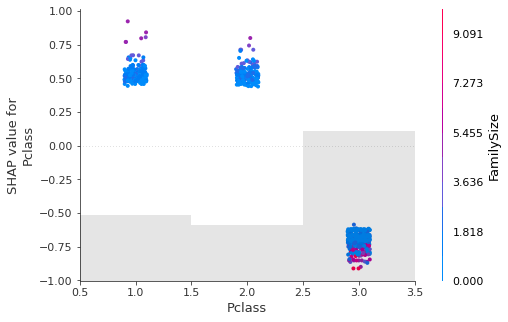

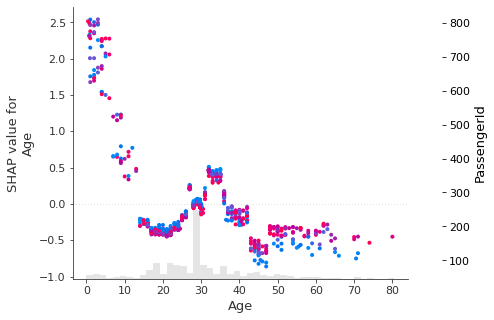

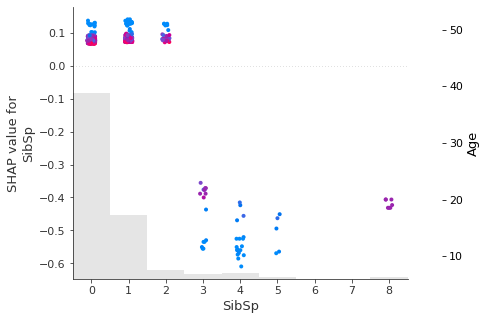

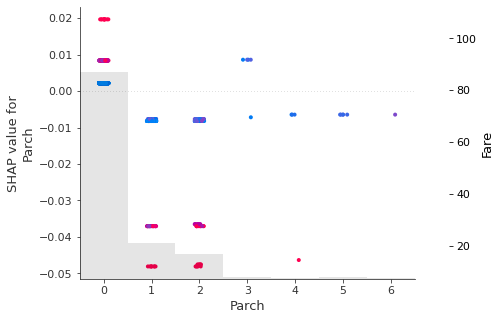

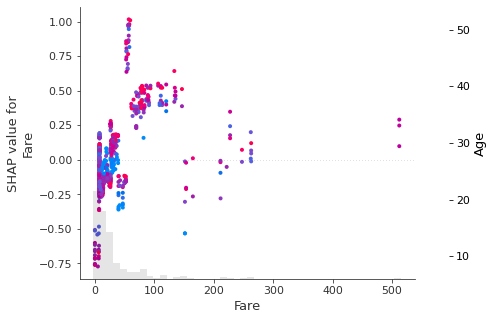

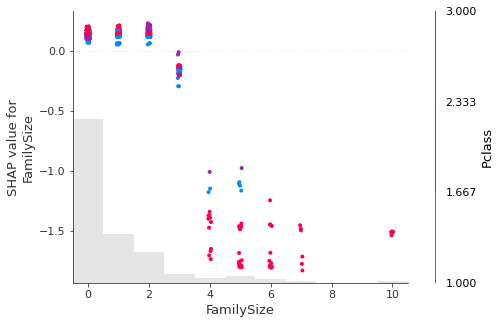

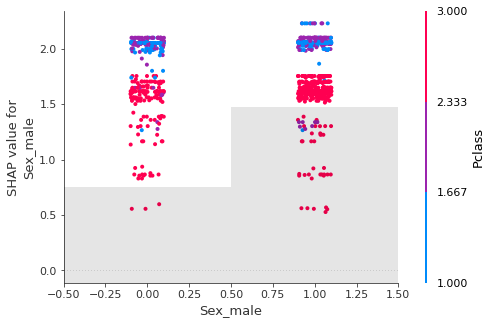

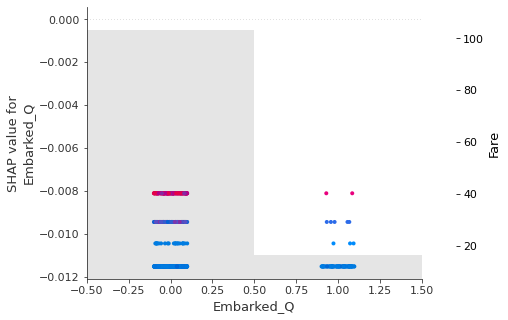

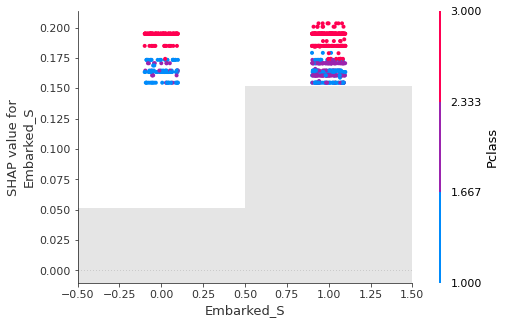

In [15]:
for feature in X.columns:
    shap.plots.scatter(shap_values[:,feature], color=shap_values)

### Force Plots:

#### Visualize the first prediction's explanation

In [16]:
shap.initjs()
shap.plots.force(shap_values[0])

#### Visualize all the predictons

In [17]:
shap.initjs()
shap.plots.force(shap_values)